# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

In [3]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [4]:
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [5]:
geo_data_2 = pd.read_csv('geo_data_2.csv')
geo_data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Данные соответствуют данному в задаче описанию. Теперь посмотрим на общую информацию о датафреймах.

In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


По общей информации видим, что все три датафрейма имеют по 5 столбцов, пропуски в них отсутствуют. Типы данных в столбцах также не вызывают подозрений.

Теперь рассмотрим распределение данных параметров скважин.

In [9]:
# функция для построения гистограммы и диаграммы размаха для заданного параметра заданного датафрейма
def hist_boxplot(df, param, region):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    df[param].hist(bins=100, ax=axs[0])
    df.boxplot(param, ax=axs[1])
    axs[0].set_ylabel(f'Частота значений параметра {param}')
    axs[0].set_xlabel(f'Значения параметра {param}')
    axs[0].set_title(f'Распределение параметра {param}')
    axs[1].set_ylabel(f'Значения параметра {param}')
    axs[1].set_title(f'Диаграмма размаха {param}')
    fig.suptitle(f'Регион - {region}, параметр - {param}', fontsize=16);

### 1ый регион

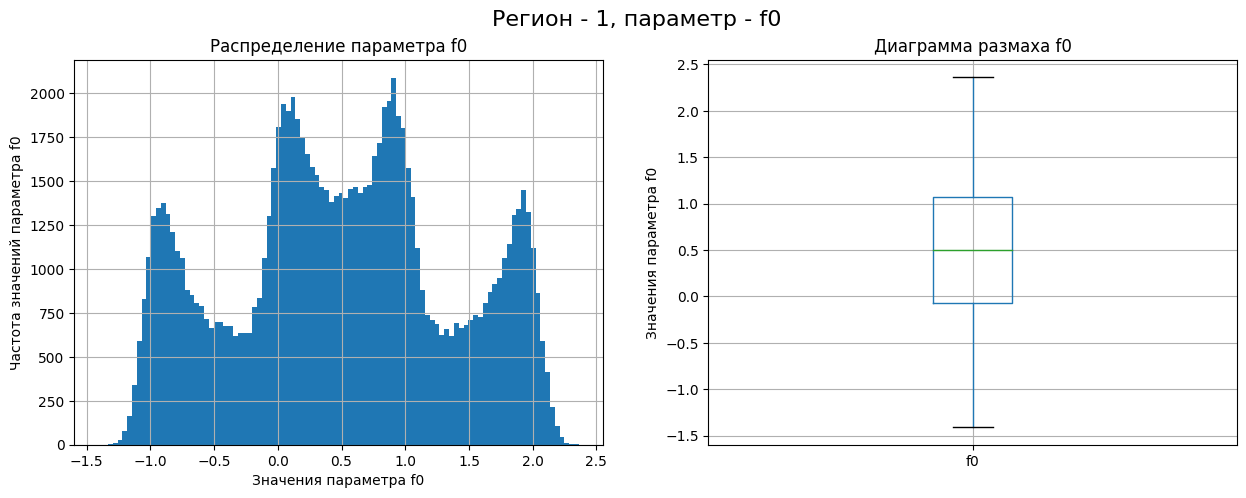

In [10]:
hist_boxplot(geo_data_0, 'f0', '1')

Видим, что параметр f0 имеет мультимодальное распределение. Согласно диаграмме размаха, выбросов нет.

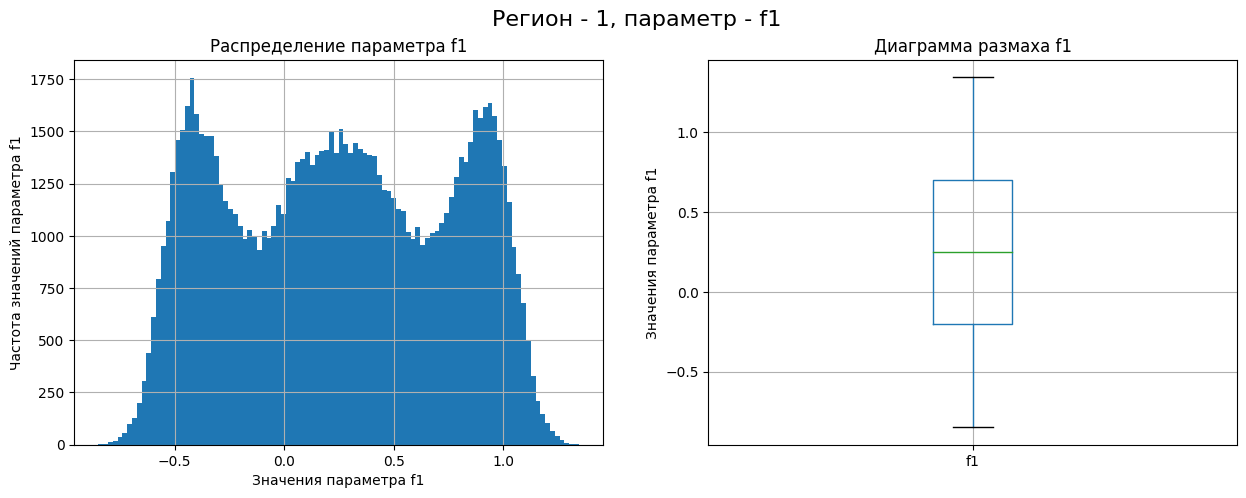

In [11]:
hist_boxplot(geo_data_0, 'f1', '1')

Параметр f1 также имеет мультимодальное распределение, выбросы отсутствуют.

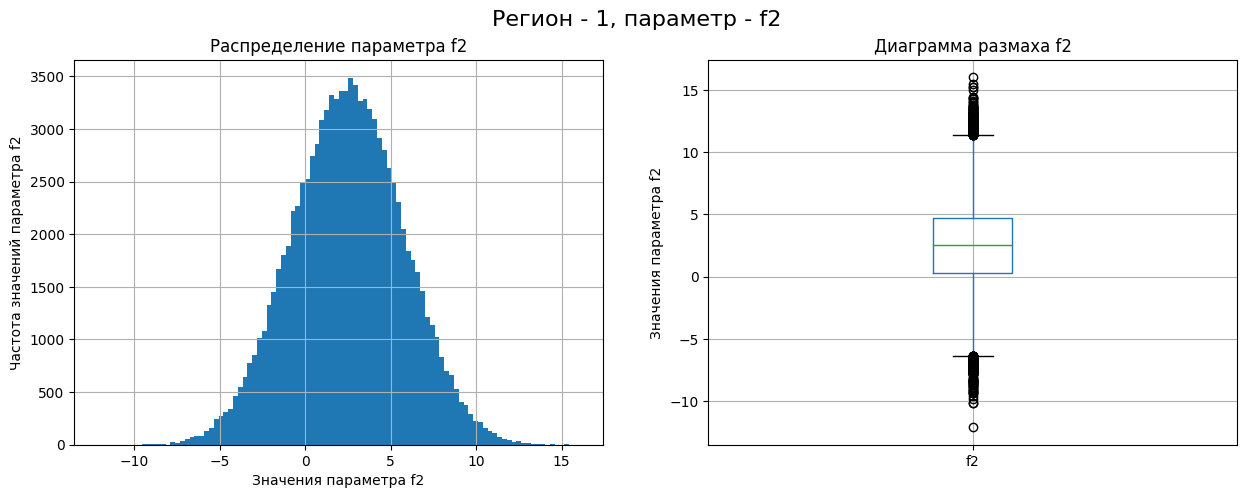

In [12]:
hist_boxplot(geo_data_0, 'f2', '1')

Параметр f2 имеет нормальное распределение. На диаграмме размаха видим, что некоторые значения были приняты за выбросы, причем как сверху так и снизу. Однако, удалять или преобразовывать эти данные не будем, так как неизвестно сущностное значение предоставленных параметров.

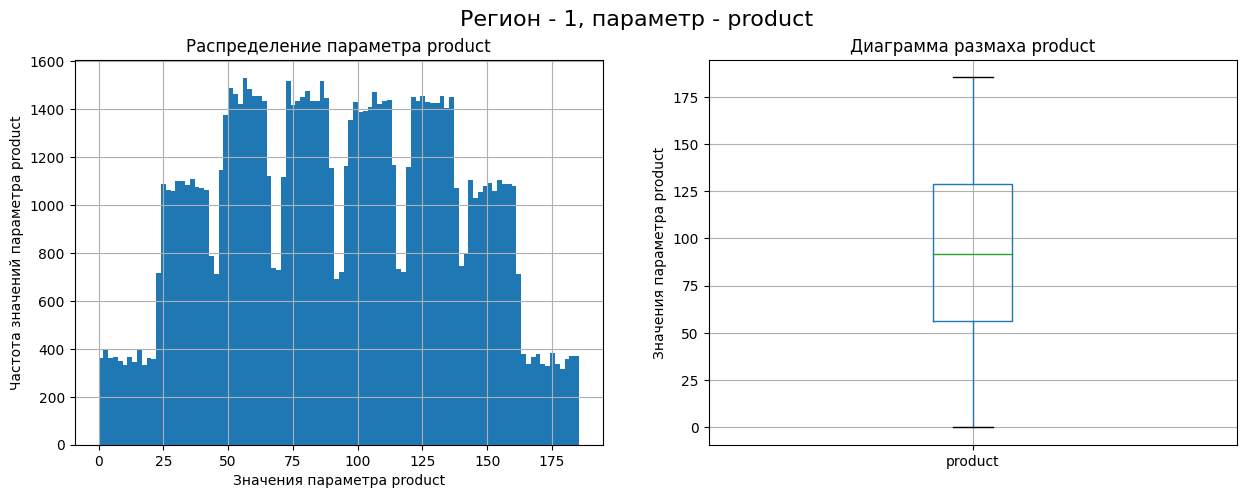

In [13]:
hist_boxplot(geo_data_0, 'product', '1')

Для параметра product видим необычное распределение, которое, в целом, также напоминает мультимодальное. Видим также, что крайние левые и правые значения сильно уступают по количеству остальным.

### 2ой регион

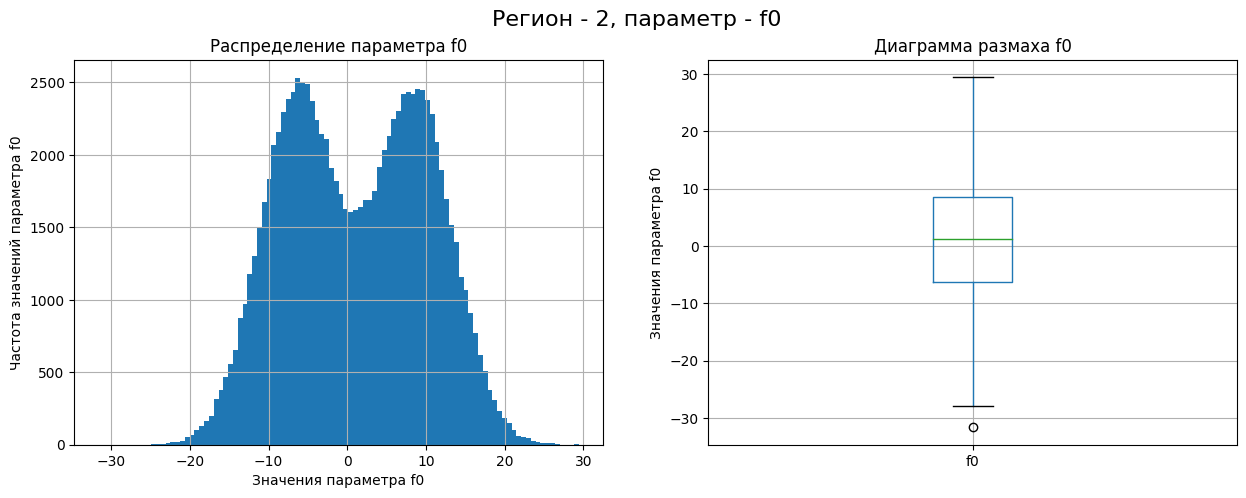

In [14]:
hist_boxplot(geo_data_1, 'f0', '2')

Для второго региона и параметра f0 видим бимодальное распределение, то есть отличающееся от первого региона. Помимо этого, видим, что диапазон значений сильно различается с первым регионом. В первом регионе диапазон условно - (-1.5;2.5), во втором - (-30;30).

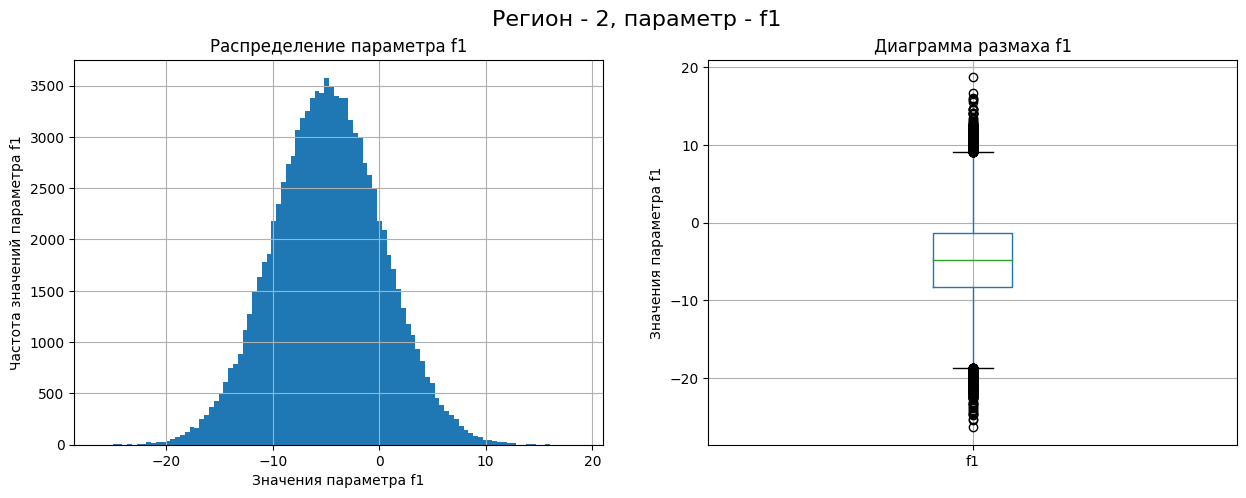

In [15]:
hist_boxplot(geo_data_1, 'f1', '2')

Видим нормальное распределение. По виду распределения и диапазону значений параметр f1 второго региона скорее соответствует параметру f2 первого региона. Посмотрим на параметр f2.

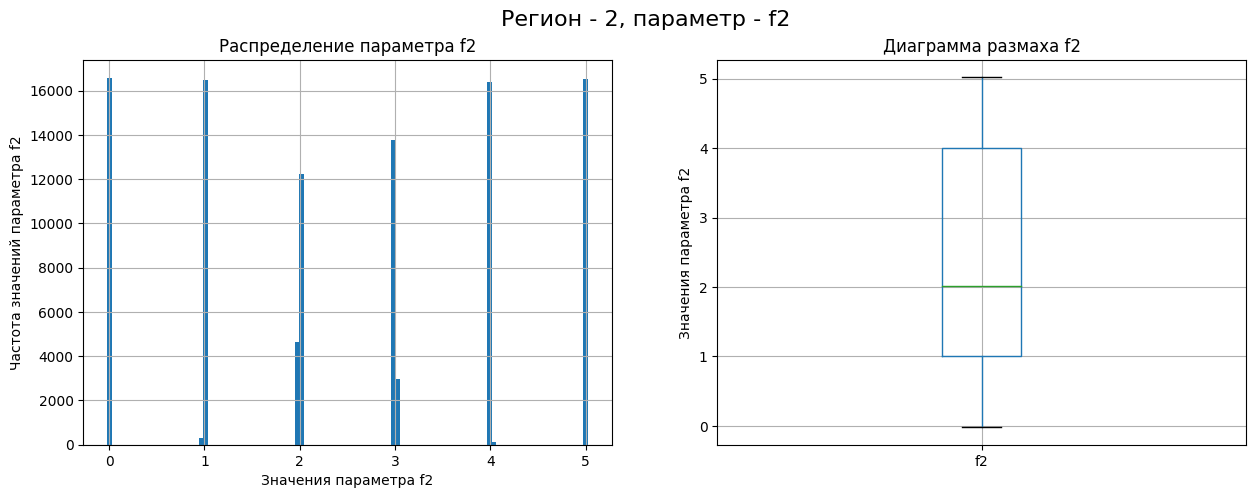

In [16]:
hist_boxplot(geo_data_1, 'f2', '2')

Для парметра f2 распределение скорее напоминает категориальный признак. Посмотрим из каких значений он состоит.

In [17]:
geo_data_1['f2'].unique()

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

In [18]:
len(geo_data_1['f2'].unique())

100000

Таким образом видим, что все значения уникальны, но они сгруппированы вокруг целых чисел от 0 до 5. В данном диапазон значений не похож ни на один для параметров первого региона. Если еще можно предположить, что f1 второго региона соответствует f2 первого региона, то относительно f0 и f2 второго региона сделать выводы не представляется возможным.

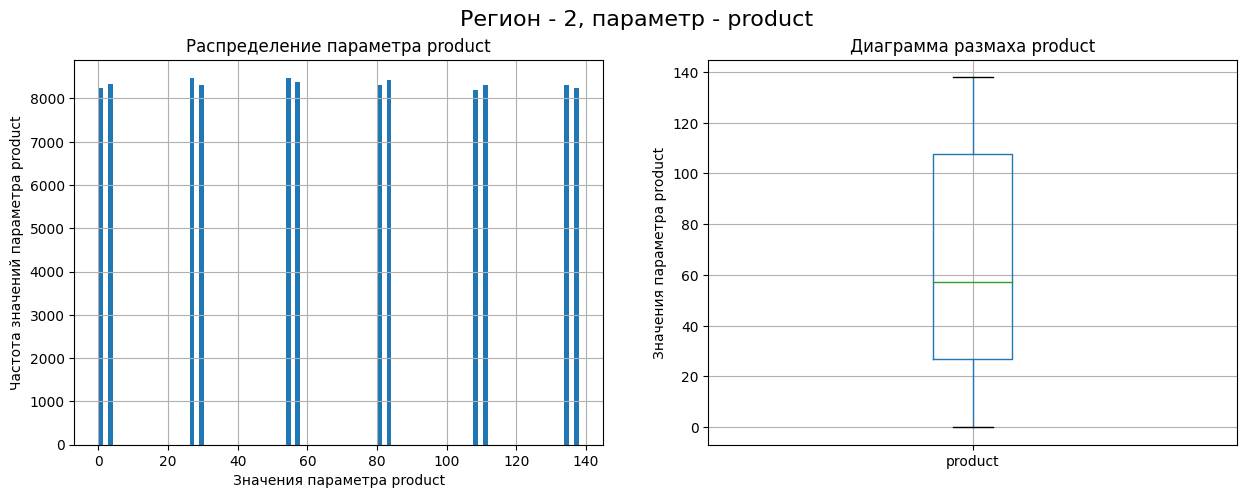

In [19]:
hist_boxplot(geo_data_1, 'product', '2')

In [20]:
geo_data_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

In [21]:
len(geo_data_1['product'].unique())

12

Параметр product второго региона имеет 12 уникальных значений. Посмотрим на данные 3его региона.

### 3ий регион

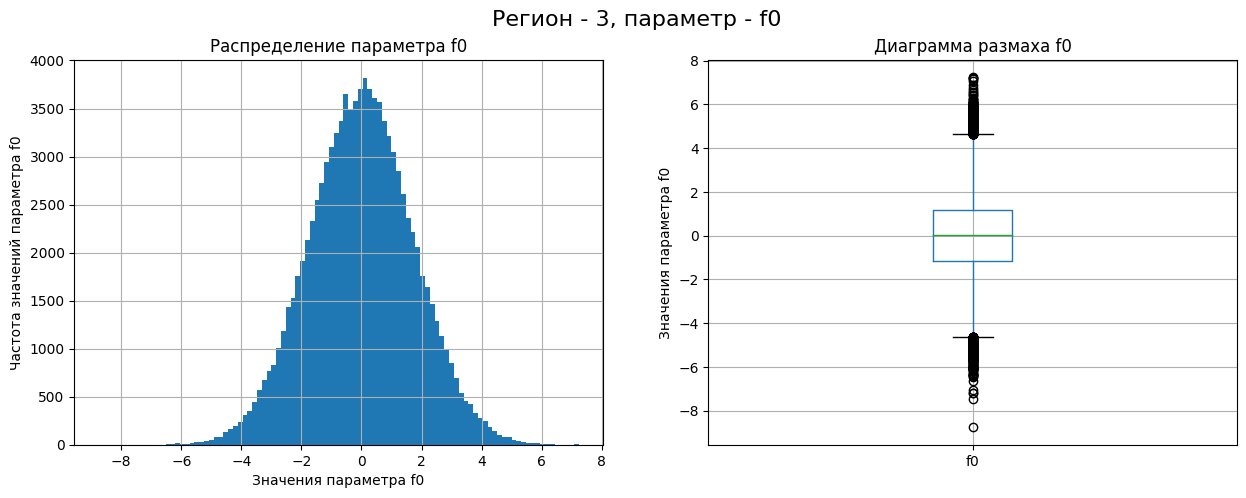

In [22]:
hist_boxplot(geo_data_2, 'f0', '3')

Параметр f0 

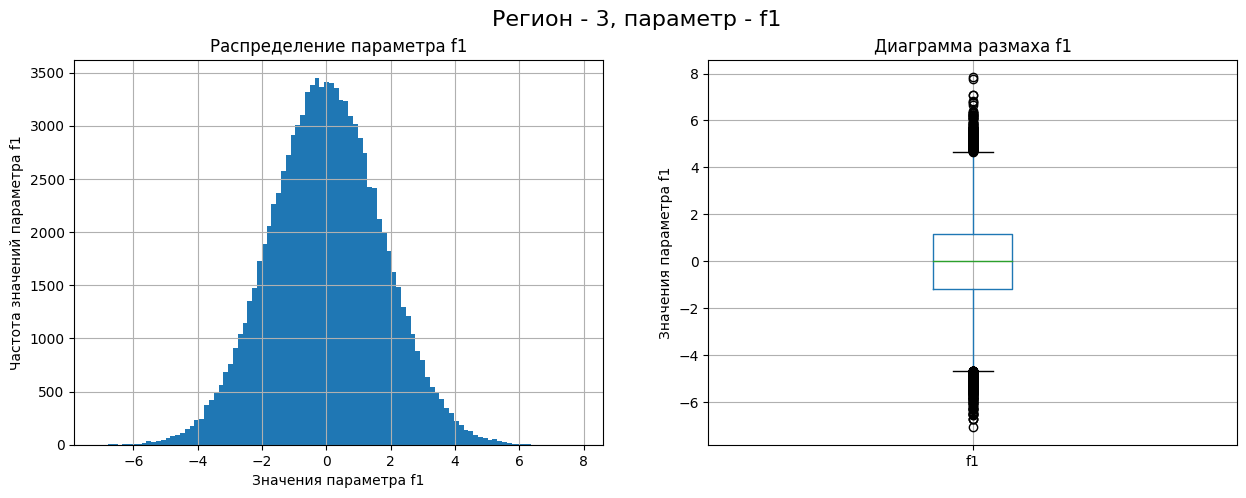

In [23]:
hist_boxplot(geo_data_2, 'f1', '3')

Параметр f1

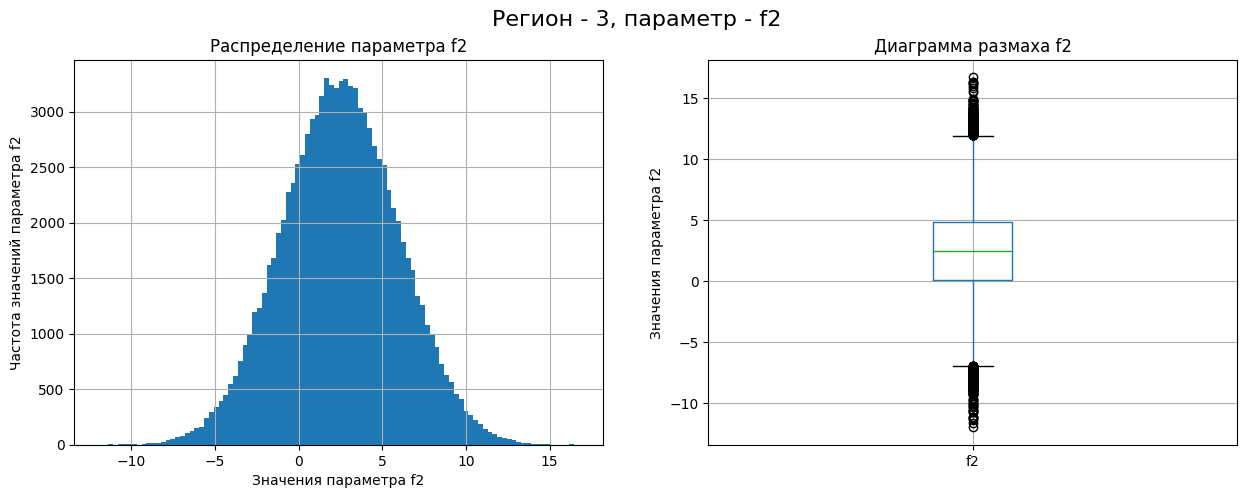

In [24]:
hist_boxplot(geo_data_2, 'f2', '3')

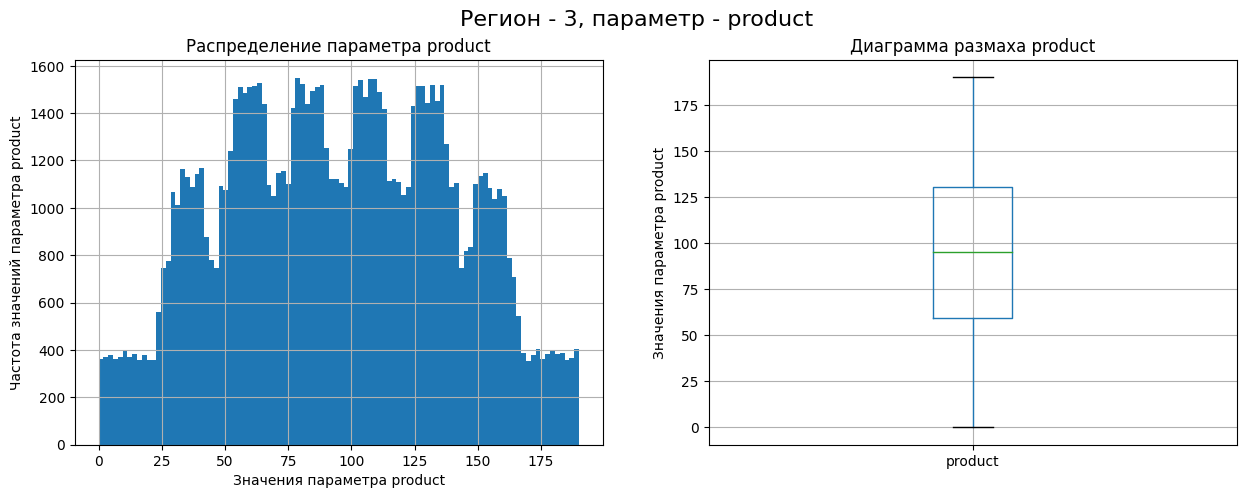

In [25]:
hist_boxplot(geo_data_2, 'product', '3')

Параметр product у третьего региона имеет распределение аналогичное первому региону.

Построим параметры f0, f1, f2 для трех регионов на одной фигуре.

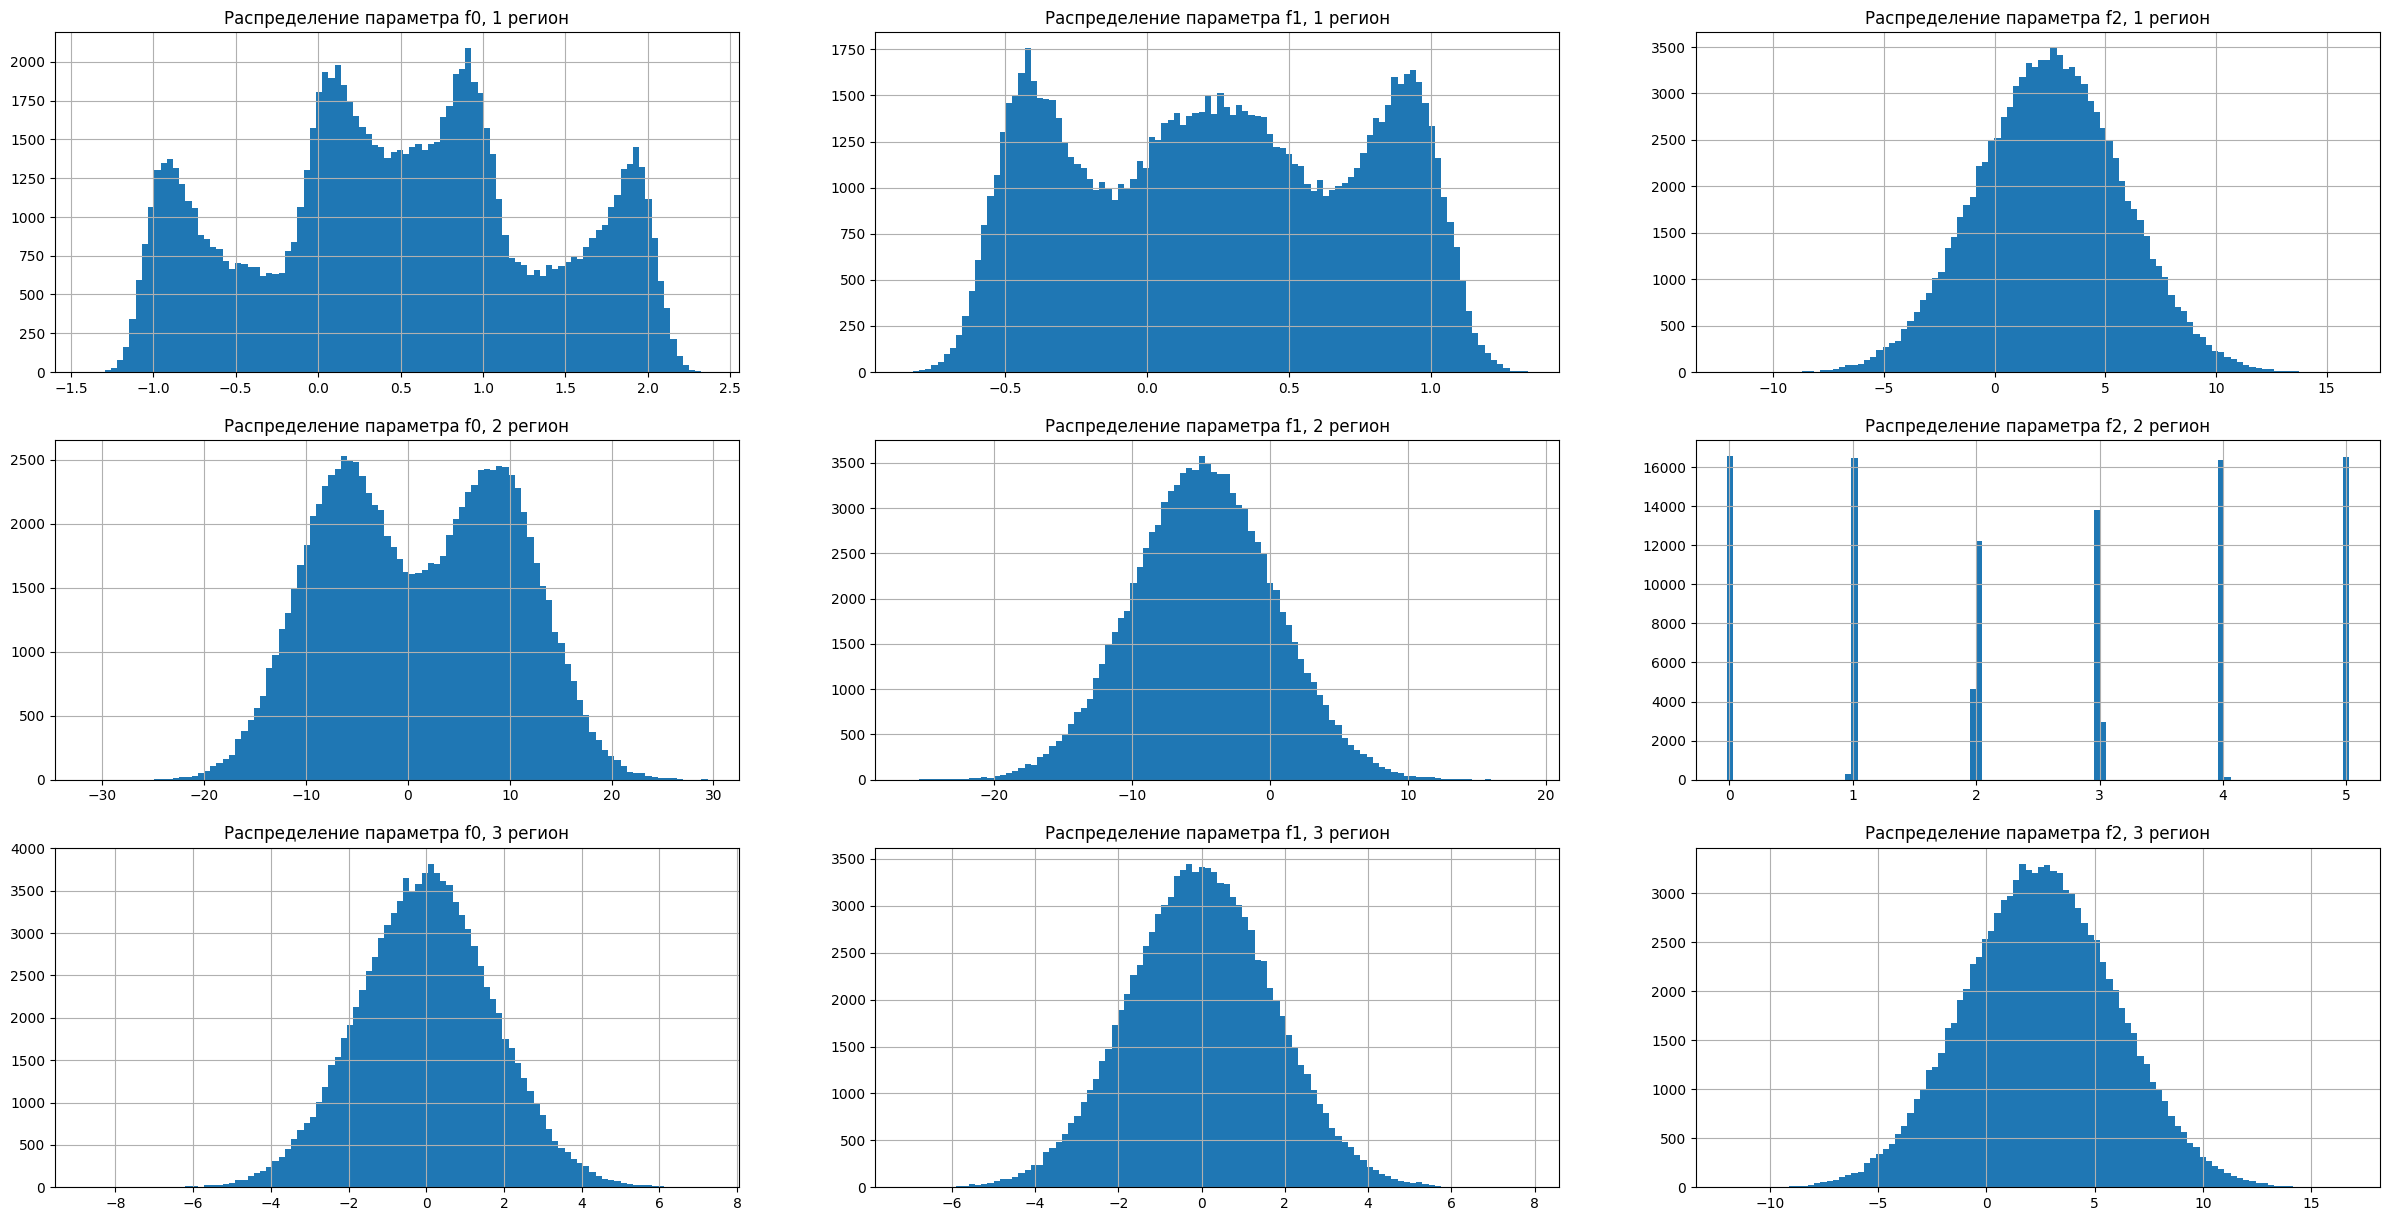

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(30, 15))
for i in range(3):
    geo_data_0[f'f{str(i)}'].hist(bins=100, ax=axs[0, i])
    axs[0, i].set_title(f'Распределение параметра f{str(i)}, 1 регион')
    geo_data_1[f'f{str(i)}'].hist(bins=100, ax=axs[1, i])
    axs[1, i].set_title(f'Распределение параметра f{str(i)}, 2 регион')
    geo_data_2[f'f{str(i)}'].hist(bins=100, ax=axs[2, i])
    axs[2, i].set_title(f'Распределение параметра f{str(i)}, 3 регион');

При сравнении распределения параметров трех регионов, видим, что похожи только параметры f2 для первого и второго региона. Остальные параметры для соответствующих регионов имеют либо отличающееся распределение, либо отличающееся "разбросы" значений. Так как модель обучается на данных каждого региона отдельно для дальнейшего предсказания запасов сырья в новых скважинах конкретно выбранного региона, то оставим данные в этом виде. Различия могут быть связаны с чем угодно, в том числе с тем, что на самом деле параметры f0, f1, f2 не обязательно действительно являются одними и теми же параметрами в каждом регионе, так как явно такая информация не указывалась.

## Обучение и проверка модели

Сначала разделим данные на входные признаки и целевой признак.

In [27]:
X0 = geo_data_0.drop(['id', 'product'], axis=1)
X0.head()

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769


In [28]:
y0 = geo_data_0['product']
y0.head()

0    105.280062
1     73.037750
2     85.265647
3    168.620776
4    154.036647
Name: product, dtype: float64

In [29]:
X1 = geo_data_1.drop(['id', 'product'], axis=1)
X1.head()

,f0,f1,f2
0,-15.001348,-8.276000,-0.005876
1,14.272088,-3.475083,0.999183
2,6.263187,-5.948386,5.001160
3,-13.081196,-11.506057,4.999415
4,12.702195,-8.147433,5.004363


In [30]:
y1 = geo_data_1['product']
y1.head()

0      3.179103
1     26.953261
2    134.766305
3    137.945408
4    134.766305
Name: product, dtype: float64

In [31]:
X2 = geo_data_2.drop(['id', 'product'], axis=1)
X2.head()

,f0,f1,f2
0,-1.146987,0.963328,-0.828965
1,0.262778,0.269839,-2.530187
2,0.194587,0.289035,-5.586433
3,2.236060,-0.553760,0.930038
4,-0.515993,1.716266,5.899011


In [32]:
y2 = geo_data_2['product']
y2.head()

0     27.758673
1     56.069697
2     62.871910
3    114.572842
4    149.600746
Name: product, dtype: float64

Теперь разобьем каждую выборку на обучающую и валидационную.

In [33]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=RANDOM_STATE)
print('Размер обучающей выборки', X0_train.shape[0], y0_train.shape[0])
print('Размер валидационной выборки', X0_test.shape[0], y0_test.shape[0])

Размер обучающей выборки 75000 75000
Размер валидационной выборки 25000 25000


In [34]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=RANDOM_STATE)
print('Размер обучающей выборки', X1_train.shape[0], y1_train.shape[0])
print('Размер валидационной выборки', X1_test.shape[0], y1_test.shape[0])

Размер обучающей выборки 75000 75000
Размер валидационной выборки 25000 25000


In [35]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=RANDOM_STATE)
print('Размер обучающей выборки', X2_train.shape[0], y2_train.shape[0])
print('Размер валидационной выборки', X2_test.shape[0], y2_test.shape[0])

Размер обучающей выборки 75000 75000
Размер валидационной выборки 25000 25000


Теперь проведем стандартизацию признаков.

In [36]:
scaler = StandardScaler()
X0_train_scaled = scaler.fit_transform(X0_train)
X0_test_scaled = scaler.transform(X0_test)

In [37]:
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

In [38]:
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

Теперь обучим модель с применением модели линейной регрессии и сделаем предсказание на валидационной выборке.

In [39]:
model_lr = LinearRegression()
model_lr.fit(X0_train_scaled, y0_train)
y0_pred = model_lr.predict(X0_test_scaled)
rmse0 = mean_squared_error(y0_test, y0_pred, squared=False)
print(f'RMSE для 1го региона - {rmse0}')
print(f'Средний запас сырья для 1го региона - {y0_pred.mean()}')

RMSE для 1го региона - 37.75660035026169
Средний запас сырья для 1го региона - 92.39879990657768


In [40]:
model_lr = LinearRegression()
model_lr.fit(X1_train_scaled, y1_train)
y1_pred = model_lr.predict(X1_test_scaled)
rmse1 = mean_squared_error(y1_test, y1_pred, squared=False)
print(f'RMSE для 1го региона - {rmse1}')
print(f'Средний запас сырья для 2го региона - {y1_pred.mean()}')

RMSE для 1го региона - 0.8902801001028838
Средний запас сырья для 2го региона - 68.7128780391376


In [41]:
model_lr = LinearRegression()
model_lr.fit(X2_train_scaled, y2_train)
y2_pred = model_lr.predict(X2_test_scaled)
rmse2 = mean_squared_error(y2_test, y2_pred, squared=False)
print(f'RMSE для 3го региона - {rmse2}')
print(f'Средний запас сырья для 3го региона - {y2_pred.mean()}')

RMSE для 3го региона - 40.14587231134218
Средний запас сырья для 3го региона - 94.77102387765939


По результатам предсказания на валидационной выборке видим, что средний запас сырья в 1 и 3 регионе больше чем во втором. Однако, при этом, для второго региона модель ошибается в среднем на 0.89 тыс. баррелей. Тогда как в 1 и 3 регионе модель ошибается в среднем на 37 и 40 тыс. баррелей. Таким образом, наблюдаем существенную разницу в работе модели линейной регресии для трех разных регионов, но однозначный вывод сделать нельзя, так как считается средняя ошибка, без учета того, в большую или меньшую она сторону. Также во втором регионе сильно отличается параметр f2 и целевой product по сравнению с первым и третьим регионом.

## Подготовка к расчёту прибыли

In [42]:
WELL_SURVEY = 500 # количество скважин для исследования
BEST_WELLS = 200 # количество лучших скважин
BUDGET = 10 * (10) ** 9 # бюджет на разработку скважин в регионе
REVENUE_PER_BARREL = 450 # доход с одного барреля
REVENUE_PER_THOUSAND_BARREL = 450 * (10) ** 3 # доход с одной тысячи баррелей

Так как безубыточности означает выход ноль, для определения объема сырья в скважине, при котором доход покроет расход, необходимо определить бюджет для одной скважины и разделить на возможный доход с одной тысячи баррелей.

In [43]:
BREAKEVEN_VOLUME_IN_THOUSANDS = (BUDGET / BEST_WELLS) / REVENUE_PER_THOUSAND_BARREL
print(f'Объем безубыточности в тысячах баррелей - {BREAKEVEN_VOLUME_IN_THOUSANDS}')

Объем безубыточности в тысячах баррелей - 111.11111111111111


Сравним объем безубыточности со средним запасом в каждом регионе.

In [44]:
print(f'1 регион - {y0.mean()}')
print(f'2 регион - {y1.mean()}')
print(f'3 регион - {y2.mean()}')

1 регион - 92.50000000000001
2 регион - 68.82500000000002
3 регион - 95.00000000000004


Получается, что средний запас в каждом регионе ниже безубыточного объема для одной скважины. Тем не менее, в некоторых скважинах объем может привышать требуемый безубыточный объем, в связи с чем сам регион может оказаться безубыточным и даже прибыльным. Поэтому важно выбрать наиболее перспективные скважины объем запасов которых превышает средний объем в регионе.

Зададим функцию для расчета прибыли.

In [45]:
# расчет прибыли
def revenue_wells(wells_pred_ser, wells_test_ser):
    wells_pred_ser = wells_pred_ser.sort_values(ascending=False)
    wells_test_ser = wells_test_ser[wells_pred_ser.index]
    return wells_test_ser[:BEST_WELLS].sum() * REVENUE_PER_THOUSAND_BARREL

Проверим работу функции

In [46]:
test_rev_func_pred = pd.Series([i for i in range(500)]) # от 0 до 499
test_rev_func_test = pd.Series([i for i in range(499, -1, -1)]) # от 499 до 0
# лучшие 200 в конце предсказанных
# значит прибыль рассчитываем по последним двумстам реальных
test_rev_func_test[300:500].sum() * REVENUE_PER_THOUSAND_BARREL 

8955000000

In [47]:
revenue_wells(test_rev_func_pred, test_rev_func_test)

8955000000

Значения совпадают.

## Расчёт прибыли и рисков 

Для нахождения распределения прибыли применим технику Bootstrap.

In [48]:
# задаем стандартное нормальное распределение
dist = st.norm()
dist.ppf(0.5)

0.0

In [49]:
# функция для расчета средней прибыли, доверительного интервала и риска убытков
def mean_conf_int_risk(volumes_pred, volumes_test, region):
    state = np.random.RandomState(12345)
    values = []
    count_negat_rev = 0
    bootstrap_counts = 1000
    volumes_pred = pd.Series(volumes_pred).reset_index(drop=True)
    volumes_test = pd.Series(volumes_test).reset_index(drop=True)
    volumes_df = pd.DataFrame({'pred':volumes_pred, 'test':volumes_test})
    for i in range(bootstrap_counts):
        subsample = volumes_df.sample(WELL_SURVEY, replace=True, random_state=state)
        revenue = revenue_wells(subsample['pred'], subsample['test'])
        if revenue < BUDGET:
            count_negat_rev += 1
        values.append(revenue / 10 ** 9) # прибыль в млрд
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(alpha=0.95, df=len(values)-1, loc=mean, scale=values.sem())
    p_risk = count_negat_rev / bootstrap_counts
    print(f'{region} регион')
    print(f'Средняя прибыль в млрд - {mean}')
    print(f'95 % доверительный интервал - {confidence_interval}')
    print(f'Риск убытков - {p_risk}')
    # расчет доверительного интервала по формуле из теории Практикума
    left = mean + dist.ppf(0.025) * values.sem()
    right = mean + dist.ppf(0.975) * values.sem()
    print(f'Доверительный интервал (рассчитанный) - ({left}, {right})')

In [50]:
mean_conf_int_risk(y0_pred, y0_test, 1)

1 регион
Средняя прибыль в млрд - 10.435933772138663
95 % доверительный интервал - (10.418761103882687, 10.453106440394638)
Риск убытков - 0.061
Доверительный интервал (рассчитанный) - (10.418781909444633, 10.453085634832693)


In [51]:
mean_conf_int_risk(y1_pred, y1_test, 2)

2 регион
Средняя прибыль в млрд - 10.489661254411752
95 % доверительный интервал - (10.47623486608167, 10.503087642741834)
Риск убытков - 0.011
Доверительный интервал (рассчитанный) - (10.476251132834742, 10.503071375988762)


In [52]:
mean_conf_int_risk(y2_pred, y2_test, 3)

3 регион
Средняя прибыль в млрд - 10.403687927862139
95 % доверительный интервал - (10.386206714792856, 10.421169140931422)
Риск убытков - 0.071
Доверительный интервал (рассчитанный) - (10.386227894172551, 10.421147961551727)


Таким образом, для всех трех регионов средняя прибыль превышает бюджет. Нижняя граница доверительных интервалов в 95% также превышает бюджет для всех регионов. Наибольшую среднюю прибыль показывает второй регион, такеже у него наименьший риск в 1.1%. Для третьего региона видим наименьшюю прибыль, тогда как рисков убытков для него наибольший 7.1%. Первый регион показывает второе значение по прибыли и второе по риску в 6.1%.

Учитывая вышесказанное и то, что во втором регионе возможно ошибка в сборе данных, для разработки предлагается первый регион. Так как он показывает себя лучше чем третий, а значениям второго региона трудно доверять.

**Общий вывод:**
В результате работы были загружены и рассмотрены данные по скважинам в трех регионах. При рассмотрении первого региона увидели, что распределения двух параметров является мультимодальным. Во втором регионе данные третьего параметра f2 оказались подозрительными, собранными вокруг целых чисел. Также для 10000 скважин во втором регионе увидели всего 12 уникальных значений объема сырья. Скорее всего, при сборе данных во втором регионе произошла ошибка. В третьем регионе все три параметра имеют распределение близкое к нормальному.

Затем были обучены три линейных модели для предсказания объемов сырья в скважинах. Метрика RMSE показала себя практически одинаково на первом и третьем регионе. Для второго региона RMSE равна 0.89, но в данном случае это лишний раз показывает, что данным второго региона трудно доверять. Далее был расчитан объем безубыточности для одной скважины, который оказался равен 111 тыс баррелей. Средний объем запасов в скажинах во всех трех регионах меньше этого объема, поэтому важно выбрать наиболее перспективные скважины, в которых запасы превышают средний объем для каждого региона.

Была задана функция для расчета прибыли, выбирающая наилучшие скважины в заданном количестве и проведен расчет прибыли и рисков для трех регионов. Несмотря на то, что по средней прибыли себя лучше всего показал второй регион, доверять данным по нему не стоит. Первый регион показал второй результат по средней прибыли и второй по рискам. Третий регион показывает наименее высокую среднюю прибыль с наибольшим риском по сравнению с остальными регионами. По этим причинам к разработке предлагается именно первый регион.